# Sign Language Digits Recognition with Logistic Regression

## Overview the Dataset

* In this data there are 2062 sign language digits images.
* Digits are from 0 to 9, so there are 10 unique sign.
* At the beginning of tutorial we will use only sign 0 and 1 for simplicity.
* In data, sign zero is between indexes 204 and 408. Number of zero sign is 204.
* Sign one is between indexes 822 and 1027. Number of one sign is 900. Therefore, we will use 205 samples from each classes (labels).

**Note:** Actually 205 sample is very little for deep learning. But this is tutorial so it does not matter so much.
Lets prepare our X and Y arrays. X is image array (zero and one signs) and Y is label array (0 and 1).

In [1]:
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

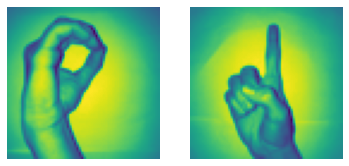

In [2]:
# load data set
x_l = np.load("archive/X.npy")
Y_l = np.load("archive/Y.npy")
img_size = 64
plt.subplot(1, 2, 1)
plt.imshow(x_l[204].reshape(img_size, img_size))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(x_l[900].reshape(img_size, img_size))
plt.axis("off")
plt.show()

In [3]:
# Join a sequence of arrays along an row axis.
X = np.concatenate((x_l[204:409], x_l[822:1027] ), axis=0) # from 204 to 409 is zero sign and from 822 to 1027 is one sign 
z = np.zeros(205)
o = np.ones(205)
y = np.concatenate((z, o), axis=0).reshape(X.shape[0], 1) # create labels: 0 -> zero sign; 1 -> one sign

print("X shape: " , X.shape)
print("y shape: " , y.shape)


# The shape of the X is (410, 64, 64):
#  - 410 means that we have 410 images (zero and one signs)
#  - 64 means that our image size is 64x64 (64x64 pixels)

# The shape of the Y is (410,1):
#  - 410 means that we have 410 labels (0 and 1)

X shape:  (410, 64, 64)
y shape:  (410, 1)


In [4]:
# We are going to create a training,test and validation array, 60% - training, 20% - test, 20% - cross validation
from sklearn.model_selection import train_test_split

# reshape dataset to remove the third dimension
X_flatten = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

# extract train sub-set
X_train, X_remain, y_train, y_remain = train_test_split(X_flatten, y, test_size=0.40, random_state=42)

# extract cross validation and test sub-sets
X_test, X_val, y_test, y_val = train_test_split(X_remain, y_remain, test_size=0.50, random_state=42)

print(f"X train flatten: {X_train.shape}")
print(f"y train: {y_train.shape}")

print(f"X val flatten: {X_val.shape}")
print(f"y val: {y_val.shape}")

print(f"X test flatten: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train flatten: (246, 4096)
y train: (246, 1)
X val flatten: (82, 4096)
y val: (82, 1)
X test flatten: (82, 4096)
y test: (82, 1)


## 1. Logistic Regression with classes script

In [5]:
def sigmoid(z):
    """
    return the sigmoid of z
    """

    gz = 1/(1 + np.exp(-z))
    
    return gz

In [6]:
def costFunctionReg(X, y, theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    # number of training examples 
    m = X.shape[0]
        
    # vector of the model predictions for all training examples      
    h = sigmoid(np.dot(X, theta))
    
    error = (-y * np.log(h)) - ((1 - y)*np.log(1-h))
    
    # cost function without regularization term
    cost = sum(error)/m
    
    # add regularization term to the cost function
    regCost = cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # gradient of theta_0
    grad_0 = (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    # vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all = np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

In [7]:
def gradientDescent(X, y, theta, alpha, num_iters, Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    Lambda is the regularization term
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        # call CostFunctionReg 
        cost, grad = costFunctionReg(X, y, theta, Lambda)
        
        # update theta
        theta = theta - (alpha * grad)
        
        J_history.append(cost)
    
    return theta , J_history

In [8]:
# number of features
n = X_train.shape[1]

# Inicialize vector theta = 0
initial_theta = np.zeros((n,1))

# Optimization hyper-parameters 
alpha = 0.01 # learning rate
num_iters = 800
Lambda = 0.1

theta , J_history = gradientDescent(X_train, y_train, initial_theta, alpha, num_iters, Lambda)

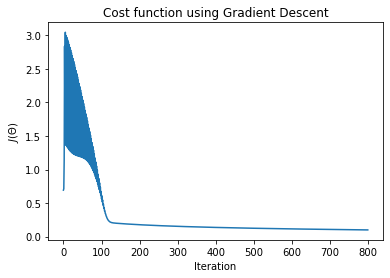

In [9]:
plt.plot(J_history)  # All classifiers
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
plt.show()

### Accuracy

In [10]:
def classifierPredict(theta, X):
    """
    take in numpy array of theta and X and predict the class 
    """
    predictions = sigmoid(np.dot(X, theta))
    
    return predictions > 0.5

In [11]:
def validationCurve(X, y, Xval, yval, learn_rate, num_iter, Lambda_array):
    """
    Returns the best lambda and the respective train and cross validation set errors
    """
    m = X.shape[0]  # Number of training examples 
    n = X.shape[1]  # number of features 
    mval = Xval.shape[0]  # Number of validation examples 
    
    error_train, error_val = [], []
    
    for lam in Lambda_array:
        print("Current Lambda: "+str(lam))

        theta_ini = np.zeros((n,1))
        theta, J_history = gradientDescent(X, y, theta_ini, learn_rate, num_iter, lam)

        h_train = classifierPredict(theta, X)
        h_val = classifierPredict(theta, Xval)

        error_train_i = (sum(y != h_train)/y.shape[0])[0]
        error_val_i = (sum(yval != h_val)/yval.shape[0])[0]

        print(error_train_i)
        print(error_val_i)

        error_train.append(error_train_i)
        error_val.append(error_val_i)
    
    ind = np.argmin(error_val)
    best_lambda = Lambda_array[ind]
        
    return best_lambda, error_train, error_val

Current Lambda: 0.01
0.024390243902439025
0.024390243902439025
Current Lambda: 0.1
0.024390243902439025
0.024390243902439025
Current Lambda: 0.3
0.024390243902439025
0.024390243902439025
Current Lambda: 1
0.024390243902439025
0.024390243902439025
Current Lambda: 3
0.024390243902439025
0.024390243902439025
Current Lambda: 10
0.02032520325203252
0.024390243902439025
Current Lambda: 30
0.028455284552845527
0.036585365853658534
Current Lambda: 35
0.02032520325203252
0.036585365853658534
Current Lambda: 40
0.028455284552845527
0.036585365853658534
Current Lambda: 45
0.032520325203252036
0.036585365853658534
Best Lambda: 0.01


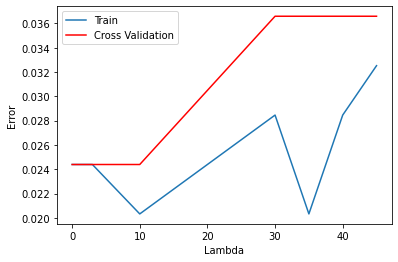

In [12]:
Lambda_array = [0.01, 0.1, 0.3, 1, 3, 10, 30, 35, 40, 45]

best_lambda, error_train, error_val = validationCurve(X_train, y_train, X_val, y_val, alpha, num_iters, Lambda_array)

print(f"Best Lambda: {best_lambda}")

plt.plot(Lambda_array,error_train,label="Train")
plt.plot(Lambda_array,error_val,label="Cross Validation", color="r")
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.legend()
plt.show()

(328, 4096)
(328, 1)


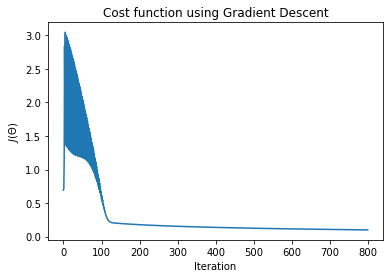

Etrain: 0.027439024390243903
Etest: 0.036585365853658534

Train Accuracy: 97.2560975609756 %
Test Accuracy: 96.34146341463415 %


In [13]:
X_train_2 = np.concatenate((X_train, X_test), axis=0)
print(X_train_2.shape)

y_train_2 = np.concatenate((y_train, y_test), axis=0)
print(y_train_2.shape)

m, n = X_train.shape
mval = X_val.shape[0]
mtest = X_test.shape[0]

theta_ini = np.zeros((n,1))
theta_optimized, J_history = gradientDescent(X_train, y_train, theta_ini, alpha, num_iters, best_lambda)

plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
plt.show()

pred_train = classifierPredict(theta_optimized, X_train_2)
Etrain = (sum(y_train_2 != pred_train)/y_train_2.shape[0])[0]

pred_test = classifierPredict(theta_optimized, X_test)
Etest = (sum(y_test != pred_test)/y_test.shape[0])[0]

print(f"Etrain: {Etrain}")
print(f"Etest: {Etest}\n")

print("Train Accuracy:", (1-Etrain)*100,"%")
print("Test Accuracy:", (1-Etest)*100,"%")